In [1]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2
import cProfile, pstats, io

In [2]:
def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

In [7]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
#data = slmdisplaysdk.createFieldUChar(200, 200)
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = 2*np.pi*grating(data.shape)/256
print(data)
error = slm.showPhasevalues(data)


shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [0.         0.         0.         ... 0.         0.         0.        ]]


(1024, 1024)


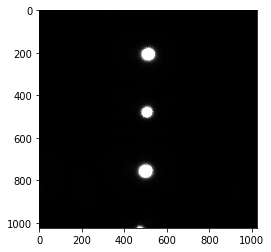

In [8]:
TargetIntensity = np.load('targetchar_15_10.npy')
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
print(TargetIntensity.shape)
plt.show()

(1088, 2048)


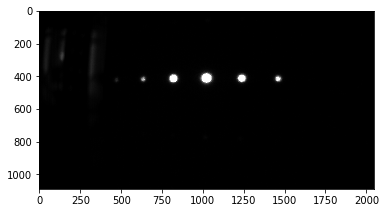

In [50]:
TargetIntensity2 = np.load('target2_char_13_10.npy')
plt.imshow(TargetIntensity2, cmap='gray', vmin=0, vmax=255)
print(TargetIntensity2.shape)
plt.show()

In [9]:
def cost(I_target, I_camera):
    return np.sum((I_target-I_camera)**2)/np.size(I_target)

In [4]:
def grating(shape):
    mask = np.zeros(shape)
    
    idx = [2*i for i in range(shape[0]//2)]
    mask[idx,:]=128
    
    return mask


#plt.imshow(grating(data.shape), cmap='gray')
#plt.show()
#print(grating())

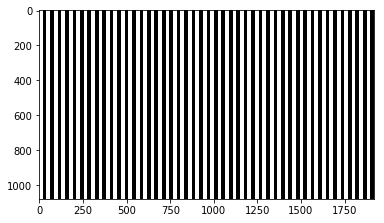

In [53]:
def vert_grating(shape):
    mask = np.zeros(shape)
    
    idx = [2*i for i in range(shape[1]//2)]
    mask[:, idx]=128
    
    return mask


plt.imshow(vert_grating(data.shape), cmap='gray')
plt.show()
#print(grating())

In [29]:
# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
#data = slmdisplaysdk.createFieldUChar(200, 200)
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = 2*np.pi*grating(data.shape)/256
print(data)
error = slm.showPhasevalues(data)


shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [11]:
@profile
def loopfunc(shape, number):
    
    numberOfImagesToGrab=0
    count = 0
    increment = 0
    img = 0
        
    target=TargetIntensity
    intensity_error = []
    phase = slmdisplaysdk.createFieldUChar(shape[1], shape[0])
    phase = 2*np.pi*grating(shape)/256
    if number == 0:
        #phase = 2*np.pi*grating(shape)/256
        #increment=108
        #target = TargetIntensity
        numberOfImagesToGrab = shape[0]
    elif number == 1:
        #phase = 2*np.pi*grating(shape)/256
        #increment=108
        #target = TargetIntensity
        numberOfImagesToGrab = shape[0]
    elif number == 2:
        #phase = 2*np.pi*vert_grating(shape)/256
        #target = TargetIntensity2
        #increment=192
        numberOfImagesToGrab = shape[1]
    elif number == 3:
        #phase = 2*np.pi*vert_grating(shape)/256
        #target = TargetIntensity2
        #increment=192
        numberOfImagesToGrab = shape[1]
    
    time_start = time.time()
    
    while count in range(numberOfImagesToGrab):
        
        if number == 0:
            
            phase[:count, :] = 0
            
            
        elif number == 1:
            
            phase[shape[0] - count:, :] = 0
            
        elif number == 2:
            
            phase[:, :count] = 0
            
        elif number == 3:
           
            phase[:, shape[1] - count:]=0
            
            
        
        #phase = 2*np.pi*grating(shape)/256
        
        #phase[:, :count] = 0
        #phase[:count, :] = 0
        #phase[shape[0] - count:, :] = 0
        error = slm.showPhasevalues(phase)
          
        time.sleep(0.2)
        camera.StartGrabbingMax(1)
        
        while camera.IsGrabbing():
            grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
            
            if grabResult.GrabSucceeded():
                
                # Access the image data.
                
                img = grabResult.Array
                
            else:
                print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
            grabResult.Release()
            
               
        
        intensity_error.append(cost(target, img))
        
        #count += increment
        #count += 1
        count += 10
        
        
    time_end = time.time()
    print(data.shape)
    print("TIME: ", time_end-time_start)
    
    return intensity_error

#row_ERROR = loopfunc(data.shape)

ERROR = []

for i in range(4):
    ERROR.append(loopfunc(data.shape, i))
    
np.save("beam_charac_15_10", ERROR)


(1080, 1920)
TIME:  47.26598811149597
         5282 function calls (5174 primitive calls) in 47.394 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.365    1.365   47.394   47.394 <ipython-input-11-4454c3b534fb>:1(loopfunc)
      108   21.630    0.200   21.630    0.200 {built-in method time.sleep}
      108   13.797    0.128   13.812    0.128 C:\Program Files\HOLOEYE Photonics\SLM Display SDK (Python) v2.0.1\python\holoeye\slmdisplaysdk\__init__.py:804(showPhasevalues)
      108    0.002    0.000    6.337    0.059 C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\pypylon\pylon.py:3393(RetrieveResult)
      108    6.329    0.059    6.335    0.059 {built-in method pypylon._pylon.InstantCamera_RetrieveResult}
      108    0.004    0.000    2.138    0.020 C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\pypylon\pylon.py:3363(StartGrabbingMax)
      108    2.134    0.020    2.134    0.020 {built-in method 

(1080, 1920)
TIME:  84.29996252059937
         9314 function calls (9122 primitive calls) in 84.493 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.460    2.460   84.493   84.493 <ipython-input-11-4454c3b534fb>:1(loopfunc)
      192   38.486    0.200   38.486    0.200 {built-in method time.sleep}
      192   23.843    0.124   23.871    0.124 C:\Program Files\HOLOEYE Photonics\SLM Display SDK (Python) v2.0.1\python\holoeye\slmdisplaysdk\__init__.py:804(showPhasevalues)
      192    0.004    0.000   11.245    0.059 C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\pypylon\pylon.py:3393(RetrieveResult)
      192   11.232    0.059   11.241    0.059 {built-in method pypylon._pylon.InstantCamera_RetrieveResult}
      192    0.007    0.000    4.060    0.021 C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\pypylon\pylon.py:3363(StartGrabbingMax)
      192    4.053    0.021    4.053    0.021 {built-in method 

In [ ]:
x = np.arange(0, 10*len(ERROR[2]),10)
y = np.arange(0, 10*len(ERROR[0]),10)

figchar, axchar = plt.subplots(2,2)

TITLEchar = []
TITLEchar.append('Rows, blackened from top to bottom')
TITLEchar.append('Rows, blackened from bottom to top')
TITLEchar.append('Columns, blackened from left to right')
TITLEchar.append('Columns, blackened from right to left')

axchar[0][0].plot(y,ERROR[0])
axchar[0][1].plot(y,ERROR[1])
axchar[1][0].plot(x,ERROR[2])
axchar[1][1].plot(x,ERROR[3])
num = 0
for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        
        axchar[i][j].set_title(TITLEchar[num])
        axchar[i][j].set_ylabel("Error in intensity")
        
        num += 1

figchar.tight_layout()
figchar.set_size_inches(18.5, 10.5)
#plt.savefig("error2.png")
axchar[0][0].set_xlabel("Number of rows blackened")
axchar[0][1].set_xlabel("Number of rows blackened")
axchar[1][0].set_xlabel("Number of columns blackened")
axchar[1][1].set_xlabel("Number of columns blackened")

plt.savefig("charplots_15_10.png")
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

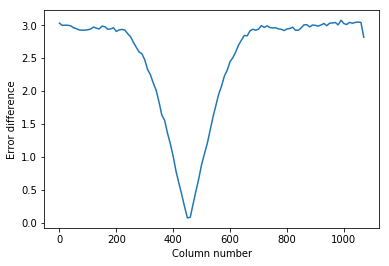

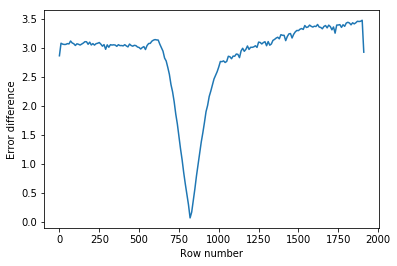

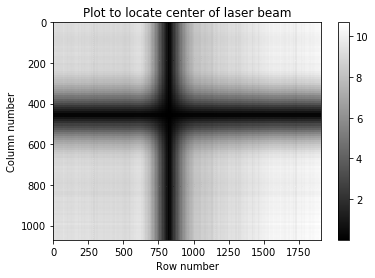

In [25]:
# FINDING OUT THE POSITION OF THE CENTER OF THE LASER BEAM

a = np.flip(ERROR[1])
           
b = np.flip(ERROR[3])

plot1= abs(a-ERROR[0])
plot2= abs(b-ERROR[2])

x = np.arange(0, 10*len(ERROR[2]),10)
y = np.arange(0, 10*len(ERROR[0]),10)

plt.plot(y,plot1)
plt.xlabel("Column number")
plt.ylabel("Error difference")
plt.savefig("diffcoloumn_15_10.png")
plt.show()
plt.plot(x,plot2)
plt.xlabel("Row number")
plt.ylabel("Error difference")
plt.savefig("diffrow_15_10.png")
plt.show()

z = []
for i in range(len(y)):
    temp = []
    for j in range(len(x)):
        temp.append(plot1[i]*plot2[j])
    z.append(temp)
    
plt.pcolor(x, y, z, cmap='gray')
plt.gca().invert_yaxis()
plt.xlabel("Row number")
plt.ylabel("Column number")
plt.title("Plot to locate center of laser beam")
plt.colorbar()
plt.savefig("spot_location_15_10.png")
plt.show()

In [ ]:
plt.imshow(data, cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("Binary Horizontal Grating")
plt.savefig("char_grating_15_!0.png")
plt.show()

In [ ]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None

# Following cells are data processing from initial runs

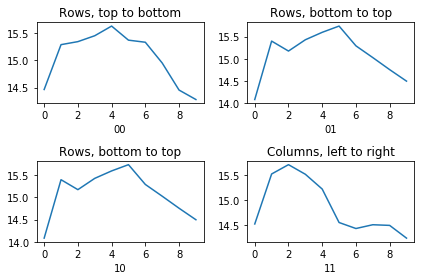

In [44]:
fig1, ax1 = plt.subplots(2,2)
TITLE1 = []
TITLE1.append('Rows, top to bottom')
TITLE1.append('Rows, bottom to top')
TITLE1.append('Columns, left to right')
TITLE1.append('Columns, right to left')

for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        ax1[i][j].plot(arr1[i+j])
        ax1[i][j].set_title(TITLE1[i+j])
        ax1[i][j].set_xlabel(str(i) + str(j))

fig1.tight_layout()
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

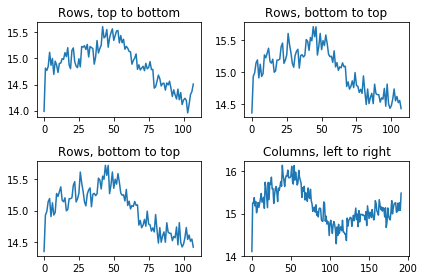

In [39]:
#arr = []

fig, ax = plt.subplots(2,2)
TITLE = []
TITLE.append('Rows, top to bottom')
TITLE.append('Rows, bottom to top')
TITLE.append('Columns, left to right')
TITLE.append('Columns, right to left')

for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        ax[i][j].plot(arr[i+j])
        ax[i][j].set_title(TITLE[i+j])

fig.tight_layout()
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

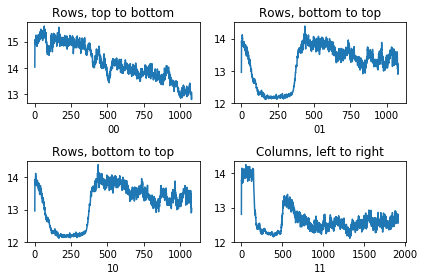

In [43]:
fig2, ax2 = plt.subplots(2,2)
TITLE2 = []
TITLE2.append('Rows, top to bottom')
TITLE2.append('Rows, bottom to top')
TITLE2.append('Columns, left to right')
TITLE2.append('Columns, right to left')

for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        ax2[i][j].plot(arr2[i+j])
        ax2[i][j].set_title(TITLE2[i+j])
        ax2[i][j].set_xlabel(str(i) + str(j))

fig2.tight_layout()
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

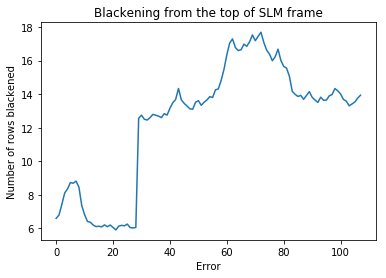

In [24]:
#count = np.arange(1, len(intensity_error)+1, 1)
plt.plot(row_ERROR)
#np.save("error_toptobottom", row_ERROR)

plt.xlabel("Error")
plt.ylabel("Number of rows blackened")
plt.title("Blackening from the top of SLM frame")
#plt.savefig("error_toptobottom.png")

plt.show()


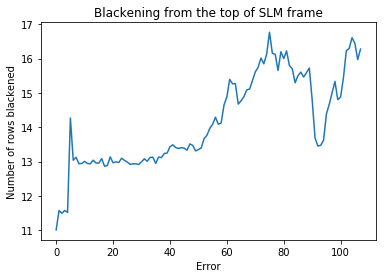

In [26]:
#count = np.arange(1, len(intensity_error)+1, 1)
plt.plot(row_ERROR)
#np.save("error_toptobottom", row_ERROR)

plt.xlabel("Error")
plt.ylabel("Number of rows blackened")
plt.title("Blackening from the top of SLM frame")
#plt.savefig("error_toptobottom.png")

plt.show()


In [26]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None

AssertionError: b'The SLM could not be initialized or was disconnected.'

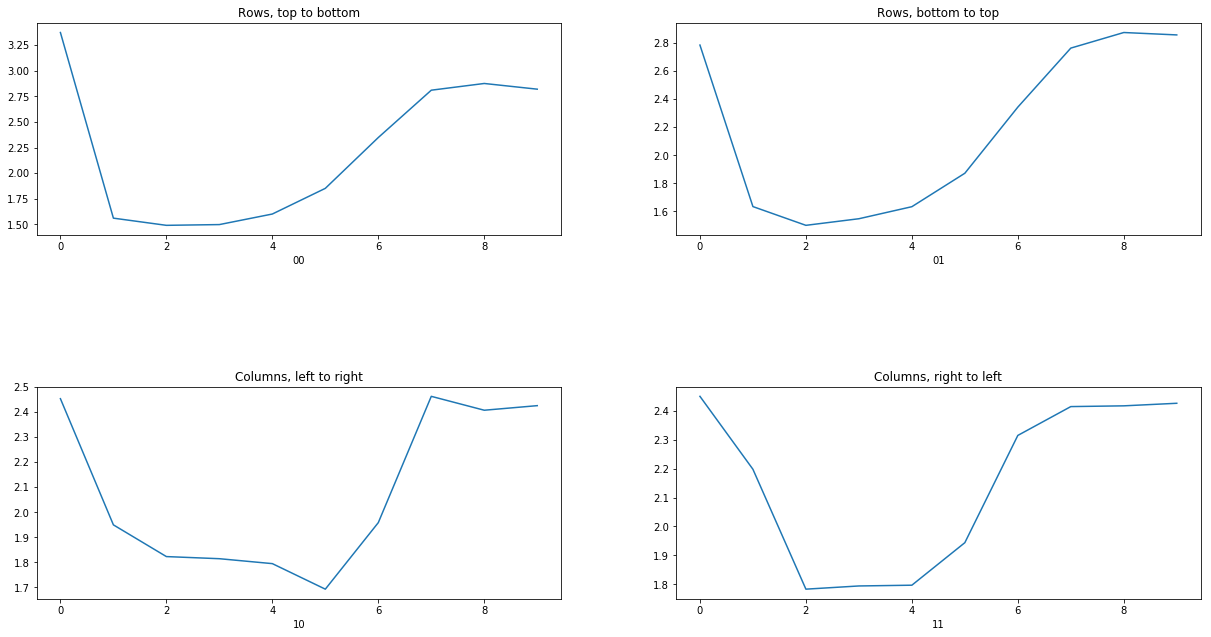

In [65]:
fig3, ax3 = plt.subplots(2,2)
TITLE3 = []
TITLE3.append('Rows, top to bottom')
TITLE3.append('Rows, bottom to top')
TITLE3.append('Columns, left to right')
TITLE3.append('Columns, right to left')

num = 0
for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        ax3[i][j].plot(arr3[num])
        ax3[i][j].set_title(TITLE3[num])
        ax3[i][j].set_xlabel(str(i) + str(j))
        num += 1

fig3.tight_layout()
fig3.set_size_inches(18.5, 10.5)
plt.savefig("error1.png")
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

In [69]:
np.save("10_iters", arr3)

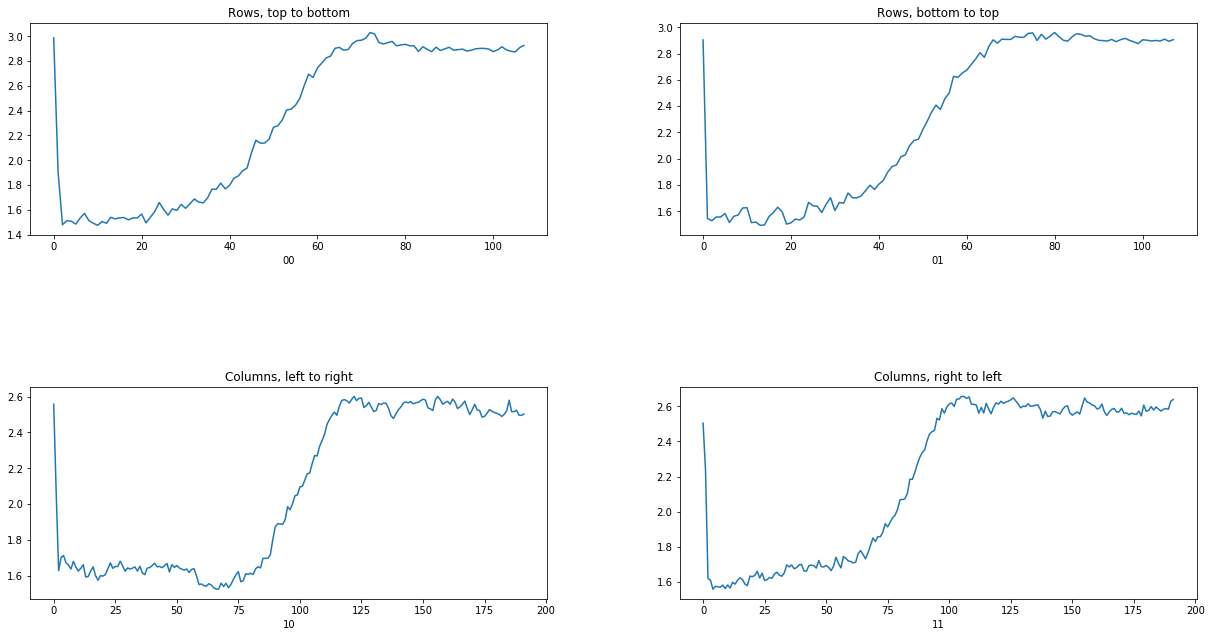

In [67]:
fig4, ax4 = plt.subplots(2,2)
TITLE4 = []
TITLE4.append('Rows, top to bottom')
TITLE4.append('Rows, bottom to top')
TITLE4.append('Columns, left to right')
TITLE4.append('Columns, right to left')

num = 0
for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        ax4[i][j].plot(arr4[num])
        ax4[i][j].set_title(TITLE4[num])
        ax4[i][j].set_xlabel(str(i) + str(j))
        num += 1

fig4.tight_layout()
fig4.set_size_inches(18.5, 10.5)
plt.savefig("error2.png")
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

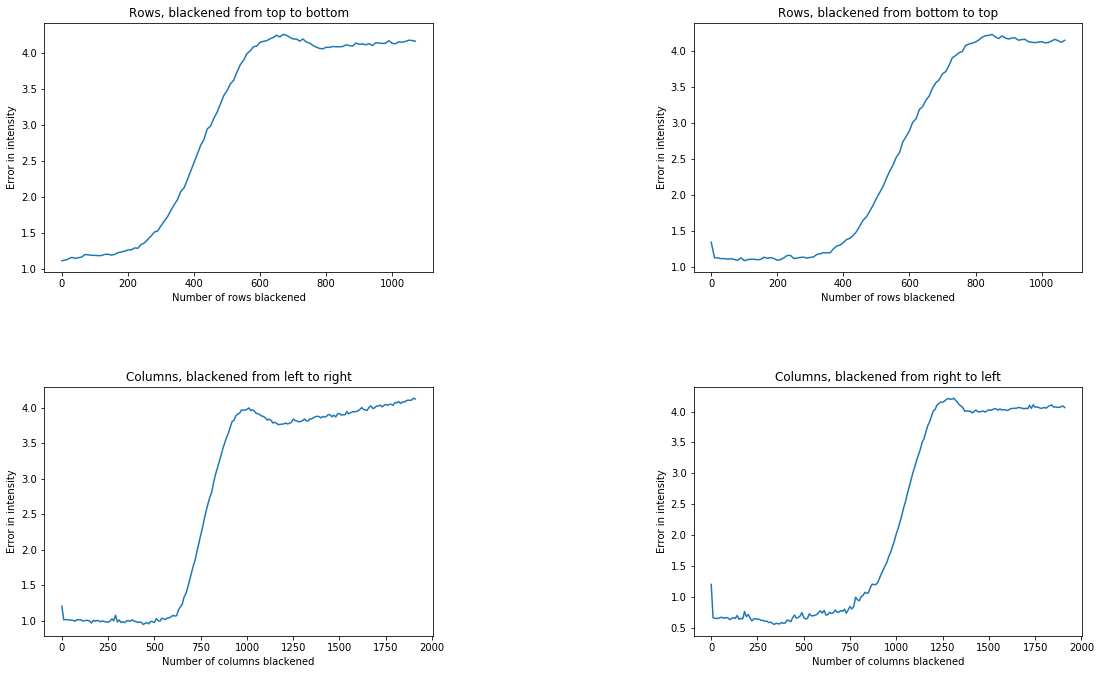

In [20]:
x = np.arange(0, 10*len(ERROR[2]),10)
y = np.arange(0, 10*len(ERROR[0]),10)

figchar, axchar = plt.subplots(2,2)

TITLEchar = []
TITLEchar.append('Rows, blackened from top to bottom')
TITLEchar.append('Rows, blackened from bottom to top')
TITLEchar.append('Columns, blackened from left to right')
TITLEchar.append('Columns, blackened from right to left')

axchar[0][0].plot(y,ERROR[0])
axchar[0][1].plot(y,ERROR[1])
axchar[1][0].plot(x,ERROR[2])
axchar[1][1].plot(x,ERROR[3])
num = 0
for i in range(2):
    for j in range(2):
        
        #arr.append(loopfunc(data.shape, i))
        
        axchar[i][j].set_title(TITLEchar[num])
        axchar[i][j].set_ylabel("Error in intensity")
        
        num += 1

figchar.tight_layout()
figchar.set_size_inches(18.5, 10.5)
#plt.savefig("error2.png")
axchar[0][0].set_xlabel("Number of rows blackened")
axchar[0][1].set_xlabel("Number of rows blackened")
axchar[1][0].set_xlabel("Number of columns blackened")
axchar[1][1].set_xlabel("Number of columns blackened")

plt.savefig("charplots_15_10.png")
plt.show()

#row_ERROR_ttb
#row_ERROR_btt
#column_ERROR_ltr
#column_ERROR_rtl

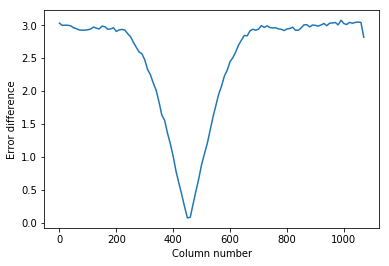

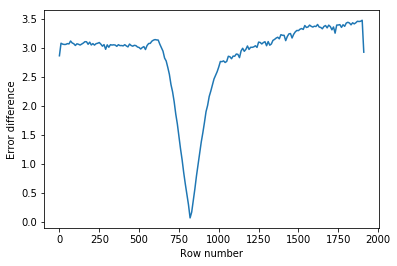

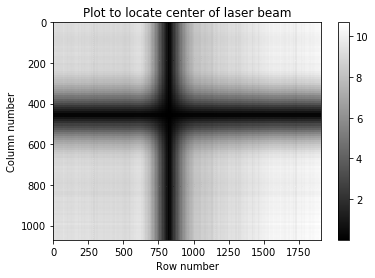

In [24]:
# FINDING OUT THE POSITION OF THE CENTER OF THE LASER BEAM

a = np.flip(ERROR[1])
           
b = np.flip(ERROR[3])

plot1= abs(a-ERROR[0])
plot2= abs(b-ERROR[2])

x = np.arange(0, 10*len(ERROR[2]),10)
y = np.arange(0, 10*len(ERROR[0]),10)

plt.plot(y,plot1)
plt.xlabel("Column number")
plt.ylabel("Error difference")
plt.show()
plt.plot(x,plot2)
plt.xlabel("Row number")
plt.ylabel("Error difference")
plt.show()

z = []
for i in range(len(y)):
    temp = []
    for j in range(len(x)):
        temp.append(plot1[i]*plot2[j])
    z.append(temp)
    
plt.pcolor(x, y, z, cmap='gray')
plt.gca().invert_yaxis()
plt.xlabel("Row number")
plt.ylabel("Column number")
plt.title("Plot to locate center of laser beam")
plt.colorbar()

In [18]:
np.save("beam_charac_15_10", ERROR)

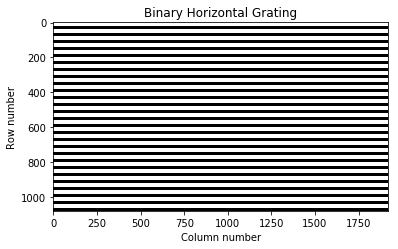

In [31]:
plt.imshow(data, cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("Binary Horizontal Grating")
plt.savefig("char_grating_15_!0.png")
plt.show()